In [1]:
import torch
import numpy as np
import slayerSNN as snn
from pathlib import Path
import logging
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
input_size = 156
hidden_size = 32
output_size = 20
lr = 0.01

data_dir='/home/tasbolat/some_python_examples/data_VT_SNN_2/'
batch_size=1
sample_file=2
epochs = 2000

In [3]:
class ViTacDataset(Dataset):
    def __init__(self, path, sample_file, output_size):
        self.path = path
        self.output_size = output_size
        sample_file = Path(path) / sample_file
        self.samples = np.loadtxt(sample_file).astype("int")
        tact = torch.load(Path(path) / "tact.pt")
        self.tact = tact.reshape(tact.shape[0], -1, 1, 1, tact.shape[-1])

    def __getitem__(self, index):
        input_index = self.samples[index, 0]
        class_label = self.samples[index, 1]
        target_class = torch.zeros((self.output_size, 1, 1, 1))
        target_class[class_label, ...] = 1
    
        return (
            self.tact[input_index],
            torch.tensor(0),
            target_class,
            class_label,
        )

    def __len__(self):
        return self.samples.shape[0]

In [4]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10,
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 325,
            },
            "tgtSpikeCount": {True: 150, False: 5},
        }
    },
}

In [15]:
class SlayerMLP(torch.nn.Module):
    '''
    2 layer MLP based on SLAYER used for tactile data
    '''
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SlayerMLP, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_output = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))
        self.spike_trains = [spike_1]
        return spike_output

class SlayerVisMLP(torch.nn.Module):
    def __init__(self, netParams, hidden_size, output_size):
        super(SlayerVisMLP, self).__init__()
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.fc1 = self.slayer.dense((50, 63, 2), hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def forward(self, downsampled):
        spike_1 = self.slayer.spike(self.slayer.psp(downsampled)) # 32, 32, 16
        spike_2 = self.slayer.spike(self.fc1(self.slayer.psp(spike_1))) #  10
        spike_3 = self.slayer.spike(self.fc2(self.slayer.psp(spike_2)))
        self.spike_trains = [spike_1, spike_2]
        return spike_3

In [6]:
device = torch.device("cuda:1")

In [16]:
train_dataset = ViTacDataset(
    path=data_dir, sample_file=f"train_80_20_{sample_file}.txt", output_size=output_size
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_dataset = ViTacDataset(
    path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=output_size
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [17]:
net = SlayerMLP(params, input_size, hidden_size, output_size).to(device)
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(
    net.parameters(), lr=lr, weight_decay=0.5
)

In [18]:
# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

In [19]:
tr_losses=[]
te_losses=[]
tr_accs=[]
te_accs=[]


for epoch in range(1, epochs+1):
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.train()
    for i, (tact, _, target, label) in enumerate(train_loader):
        
        tact = tact.to(device)
        
        target = target.to(device)
        output = net.forward(tact)
        
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        loss = error.numSpikes(output, target)
        batch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #scheduler.step()
        
    tr_losses.append(batch_loss / len(train_loader.dataset) )
    tr_accs.append(correct / len(train_loader.dataset) )
    
    correct = 0
    num_samples = 0
    batch_loss = 0
    net.eval()
    with torch.no_grad():
        for i, (tact, _, target, label) in enumerate(test_loader):

            tact = tact.to(device)

            target = target.to(device)
            output = net.forward(tact)

            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            loss = error.numSpikes(output, target)
            batch_loss += loss.item()

    te_losses.append(batch_loss / len(test_loader.dataset) )
    te_accs.append(correct / len(test_loader.dataset) )
    if epoch%10 == 0:
        print('Epoch ', epoch, '---------------------------------')
        print('Train, Test acc: ', tr_accs[-1], te_accs[-1])

Epoch  10 ---------------------------------
Train, Test acc:  0.5464285714285714 0.36428571428571427
Epoch  20 ---------------------------------
Train, Test acc:  0.6553571428571429 0.36428571428571427
Epoch  30 ---------------------------------
Train, Test acc:  0.7214285714285714 0.39285714285714285
Epoch  40 ---------------------------------
Train, Test acc:  0.7339285714285714 0.34285714285714286
Epoch  50 ---------------------------------
Train, Test acc:  0.7803571428571429 0.4142857142857143
Epoch  60 ---------------------------------
Train, Test acc:  0.7839285714285714 0.42142857142857143
Epoch  70 ---------------------------------
Train, Test acc:  0.7964285714285714 0.42142857142857143
Epoch  80 ---------------------------------
Train, Test acc:  0.8071428571428572 0.36428571428571427
Epoch  90 ---------------------------------
Train, Test acc:  0.8125 0.36428571428571427
Epoch  100 ---------------------------------
Train, Test acc:  0.8267857142857142 0.34285714285714286
Ep

Epoch  840 ---------------------------------
Train, Test acc:  0.8910714285714286 0.36428571428571427
Epoch  850 ---------------------------------
Train, Test acc:  0.9053571428571429 0.4142857142857143
Epoch  860 ---------------------------------
Train, Test acc:  0.8964285714285715 0.37857142857142856
Epoch  870 ---------------------------------
Train, Test acc:  0.8785714285714286 0.4
Epoch  880 ---------------------------------
Train, Test acc:  0.8875 0.42857142857142855
Epoch  890 ---------------------------------
Train, Test acc:  0.8839285714285714 0.44285714285714284
Epoch  900 ---------------------------------
Train, Test acc:  0.8875 0.4
Epoch  910 ---------------------------------
Train, Test acc:  0.8821428571428571 0.35714285714285715


KeyboardInterrupt: 

In [11]:
#torch.save(net.state_dict(), 'tactile_model.pt')

In [12]:
str(lr)

'0.01'

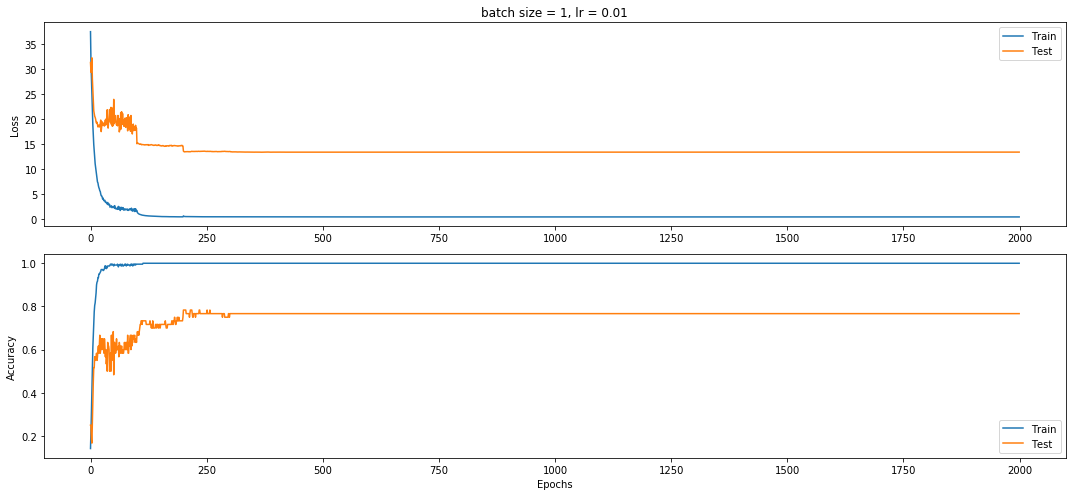

In [13]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].set_title('batch size = ' + str(batch_size) + ', lr = ' + str(lr))
ax[0].plot(tr_losses)
ax[0].plot(te_losses)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Loss')

ax[1].plot(tr_accs)
ax[1].plot(te_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.tight_layout()
#fig.savefig('results/tact_'+str(batch_size) + '_' + str(lr) +'.png')

plt.show()

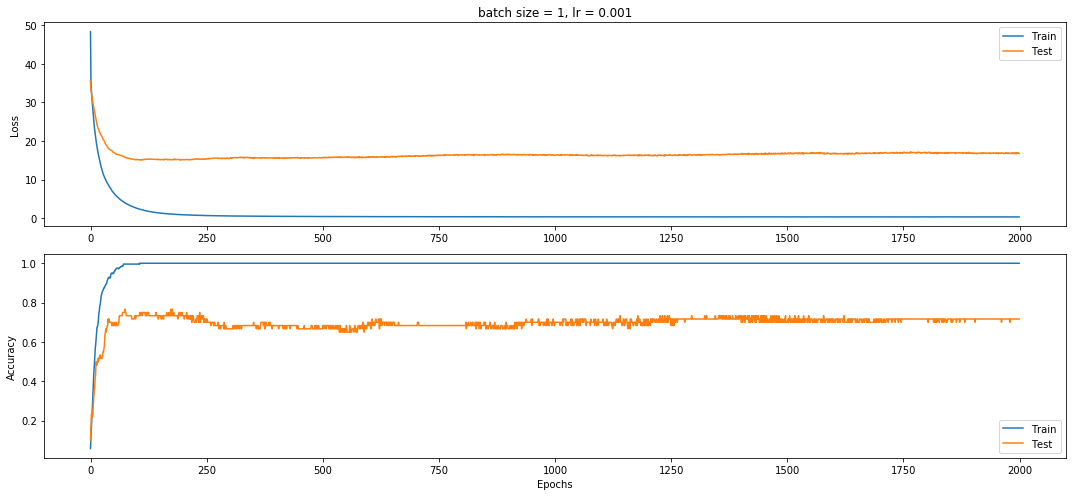

In [10]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].set_title('batch size = ' + str(batch_size) + ', lr = ' + str(lr))
ax[0].plot(tr_losses)
ax[0].plot(te_losses)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Loss')

ax[1].plot(tr_accs)
ax[1].plot(te_accs)
ax[1].legend(['Train', 'Test'])
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.tight_layout()
#fig.savefig('results/tact_'+str(batch_size) + '_' + str(lr) +'.png')

plt.show()

In [87]:
te_losses

[33.29823481241862,
 31.459618886311848,
 29.8484135945638,
 30.288387552897134,
 28.527900187174478,
 27.46533660888672,
 26.752591959635417,
 26.02743771870931,
 25.778207524617514,
 25.699003092447917,
 25.432925923665366,
 24.102591959635415,
 22.787387212117512,
 22.16041259765625,
 21.978104909261067,
 21.835207494099937,
 21.64546432495117,
 21.307591756184895,
 20.514284006754558,
 20.062822596232095,
 19.63369483947754,
 19.477258936564127,
 19.301463445027668,
 19.286309560139973,
 19.299181111653645,
 19.326822408040364,
 19.37961743672689,
 19.77946332295736,
 19.632566197713217,
 19.80777079264323,
 19.32512995402018,
 18.99036038716634,
 18.849129740397135,
 18.67423261006673,
 18.461232248942057,
 18.483514277140298,
 18.421873219807942,
 18.40082155863444,
 18.27846310933431,
 18.073642603556316,
 18.153462727864582,
 18.752411142985025,
 18.387103780110678,
 18.325514221191405,
 18.35530865987142,
 18.131642278035482,
 18.376128896077475,
 18.984667587280274,
 18.19223